In [222]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
ddf_patients = dd.read_csv('../data/raw/train/patients.csv')
ddf_procedures = dd.read_csv('../data/raw/train/procedures.csv')
ddf_conditions = dd.read_csv('../data/raw/train/conditions.csv')
ddf_encounters = dd.read_csv('../data/raw/train/encounters.csv')

In [3]:
covid_patients_ids = ddf_conditions[ddf_conditions.CODE == 840539006].PATIENT.unique().compute()

In [4]:
vent_ids = ddf_procedures[(ddf_procedures.CODE == 26763009) & (ddf_procedures.PATIENT.isin(covid_patients_ids))].PATIENT.compute()
icu_ids = ddf_encounters[(ddf_encounters.CODE == 305351004) & (ddf_encounters.PATIENT.isin(covid_patients_ids))].PATIENT.compute()

In [33]:
ddf_icu_encounters = ddf_encounters[(ddf_encounters.CODE == 305351004) & (ddf_encounters.PATIENT.isin(covid_patients_ids))]
days_in_icu = ((ddf_icu_encounters['STOP'].astype('M8[s]') - ddf_icu_encounters['START'].astype('M8[s]')).astype('timedelta64[s]').astype(float)/86400).compute()

In [41]:
patient_list = ddf_icu_encounters.PATIENT.values.compute()

In [42]:
patient_list

array(['c58ae02e-235e-4db2-a9c3-6926e9c0c5fa',
       '52e1f151-e98b-4163-a250-5e7d5c6ff813',
       '534e1ef3-b3c7-42da-a022-fea54d6c828f', ...,
       '9529dc13-c7f1-4f76-b903-4e310b7805c8',
       '65d3785a-6150-4b86-8842-c40ca654e3c4',
       '8722685f-ce37-4520-ab95-22b6929526c2'], dtype=object)

In [207]:
icu_target = pd.DataFrame(days_in_icu.values, columns=['DAYS_IN_ICU'], index=patient_list)

In [208]:
icu_target

,DAYS_IN_ICU
c58ae02e-235e-4db2-a9c3-6926e9c0c5fa,7.128472
52e1f151-e98b-4163-a250-5e7d5c6ff813,9.399306
534e1ef3-b3c7-42da-a022-fea54d6c828f,7.151389
5158d043-8c93-4987-8fcb-5f94e7e32fa1,5.811806
b5499d4a-6660-4b09-bfc0-e3d33e3dcb5e,7.941667
...,...
9c92df1f-e325-43c2-9bc0-1380eeaf3958,6.694444
6cda9ea0-5264-4465-9a9c-8315994a488f,5.938889
9529dc13-c7f1-4f76-b903-4e310b7805c8,4.180556
65d3785a-6150-4b86-8842-c40ca654e3c4,9.905556


# Exploration of ICU days

In [71]:
vent_ids_by_date = ddf_procedures[(ddf_procedures.CODE == 26763009) & (ddf_procedures.PATIENT.isin(covid_patients_ids))].DATE.compute()

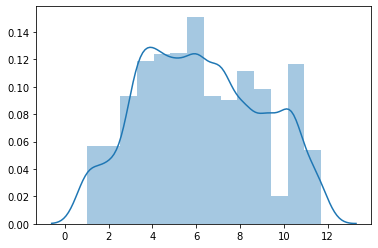

In [58]:
sns.distplot(days_in_icu, bins=14)

In [132]:
encounter_count = ddf_encounters[(ddf_encounters['PATIENT'].isin(patient_list)) & (ddf_encounters['DESCRIPTION'] != 'Death Certification')]['PATIENT'].value_counts().compute()
condition_count = ddf_conditions[(ddf_conditions['PATIENT'].isin(patient_list))]['PATIENT'].value_counts().compute()
encounter_count.columns = ['ENCOUNTER_COUNT']
condition_count.columns = ['CONDITION_COUNT']

In [104]:
temp = (np.datetime64('NOW') - ddf_patients['BIRTHDATE'].astype('M8[D]').compute()).astype('timedelta64[Y]').astype(float)
df_age = pd.DataFrame(temp.values, index = ddf_patients.compute().Id)

In [140]:
Feature_table = pd.merge(encounter_count, condition_count, left_index=True, right_index=True)
Feature_table = pd.merge(Feature_table, df_age, left_index=True, right_index=True)
Feature_table = pd.merge(Feature_table, icu_target, left_index=True, right_index=True)
Feature_table.columns = ['ENCOUNTER_COUNT', 'CONDITION_COUNT', 'AGE', 'DAYS_IN_ICU']

In [169]:
Feature_table

,ENCOUNTER_COUNT,CONDITION_COUNT,AGE,DAYS_IN_ICU
67c0ed44-9f1f-4616-ab1f-44e5f89f9f44,664,34,84.0,3.836806
2ce307df-1751-4e89-abe9-d8c9324b3a1d,627,30,84.0,3.674306
7b81ed55-01b0-4d72-8c97-64b99c6ed1e8,626,26,82.0,4.104167
fc39e796-dfe4-4592-8d44-a0897963a9dc,626,30,81.0,8.279861
21d16b72-426b-46bb-8cae-c9148668b256,600,31,78.0,7.227778
...,...,...,...,...
4f0d06c7-00e8-4195-9cab-d97cc794f503,4,12,43.0,3.041667
c7294d50-9e8a-47c0-95e0-fa286df367eb,4,19,34.0,5.965972
26dde791-47f8-484a-97c9-20bfed728822,4,12,21.0,5.121528
a599f681-cc60-49a7-97a8-f9cba249913d,3,11,25.0,9.267361


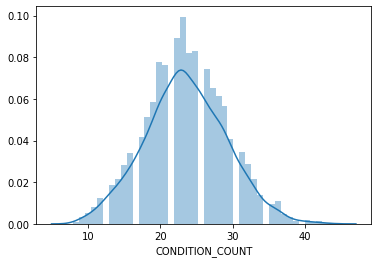

In [146]:
sns.distplot(Feature_table['CONDITION_COUNT'])

# Modelling

In [178]:
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge

X = Feature_table.iloc[:, :3].values
y = Feature_table.iloc[:, 3].values

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
reg = Lasso().fit(X, y)
print(reg.score(X, y))
reg = Ridge().fit(X, y)
print(reg.score(X, y))

0.0778863449885121
0.07143708498970458
0.07788634498479441


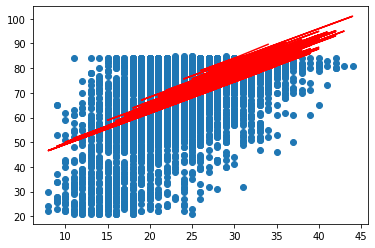

In [143]:
plt.scatter(X[:, 1], y)
plt.plot(X[:, 1], reg.predict(X), color='r')

In [110]:
df_age.columns = ['Age']

In [181]:
ddf_conditions['DESCRIPTION'].value_counts().compute().to_csv('../data/processed/condition_counts.csv')

In [182]:
conditions = ddf_conditions['DESCRIPTION'].unique().values.compute()

In [161]:
conditions_v2 = ['finding' if 'finding' in x else x for x in conditions]

In [164]:
conditions_v3 = ['fracture' if 'fracture' in x else x for x in conditions_v2]

In [167]:
conditions_v3 = [x for x in conditions_v3 if 'COVID' not in x]

# Investigating correlation between conditions and days in ICU

In [185]:
patients = ddf_conditions.PATIENT.unique().compute()
conditions = ddf_conditions.CODE.unique().compute()

In [224]:
condition_dictionary = {code: ddf_conditions[ddf_conditions['CODE']==code]['PATIENT'].values.compute() for code in conditions}

In [243]:
condition_description = pd.DataFrame(ddf_conditions['DESCRIPTION'].values.compute(), index=ddf_conditions['CODE'].values.compute()).to_dict()[0]

In [204]:
icu_target['PATIENT'] = icu_target.index

In [230]:
X_cond_1 = icu_target[icu_target.index.isin(list(condition_dictionary[conditions[0]]))].values.flatten()
X_no_cond_1 = icu_target[~icu_target.index.isin(list(condition_dictionary[conditions[0]]))].values.flatten()
X = np.concatenate([X_cond_1, X_no_cond_1])
Y = np.concatenate([np.zeros(len(X_cond_1)), np.zeros(len(X_no_cond_1))])

In [234]:
stats.pointbiserialr(Y, X)

PointbiserialrResult(correlation=nan, pvalue=nan)

-----------------
 Condition: Coronary Heart Disease 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


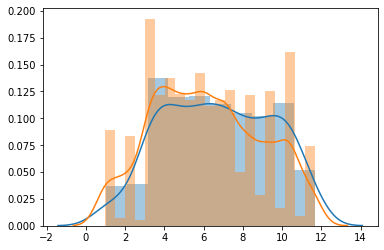

-----------------
 Condition: Acute viral pharyngitis (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


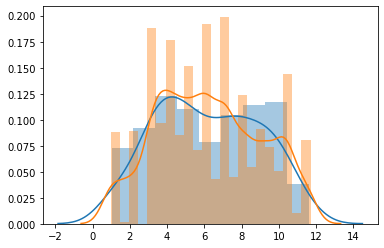

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Myocardial Infarction 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


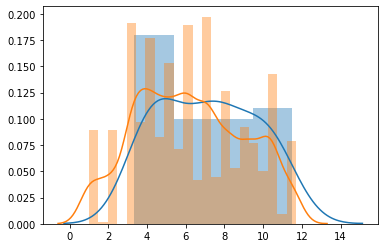

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: History of myocardial infarction (situation) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


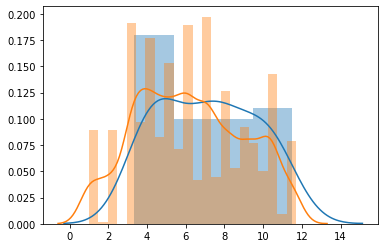

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Major depression disorder 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


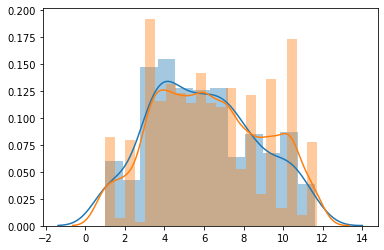

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: At risk for suicide (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


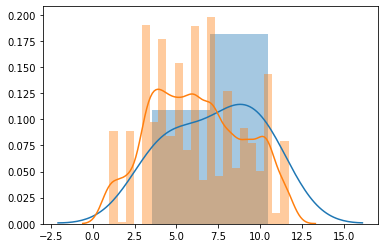

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Nasal congestion (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


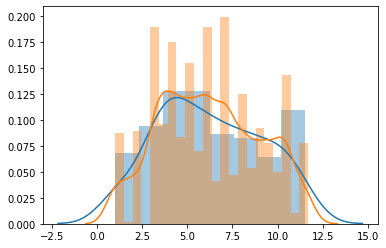

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Cough (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


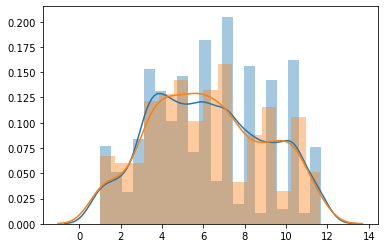

-----------------
 Condition: Chill (finding) 
-----------------


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


PointbiserialrResult(correlation=nan, pvalue=nan)


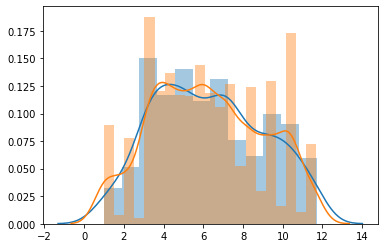

-----------------
 Condition: Fever (finding) 
-----------------


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


PointbiserialrResult(correlation=nan, pvalue=nan)


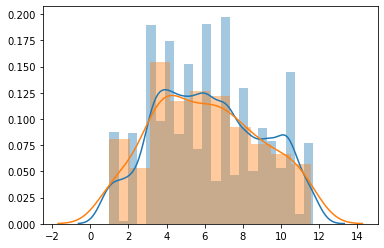

-----------------
 Condition: Suspected COVID-19 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


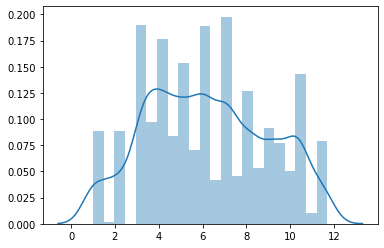

-----------------
 Condition: Hypertension 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


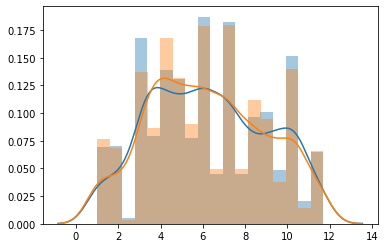

-----------------
 Condition: Prediabetes 
-----------------


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


PointbiserialrResult(correlation=nan, pvalue=nan)


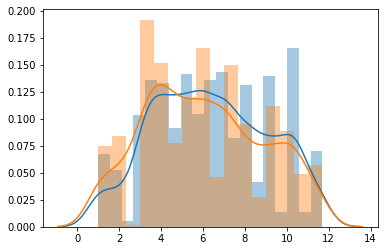

-----------------
 Condition: Anemia (disorder) 
-----------------


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


PointbiserialrResult(correlation=nan, pvalue=nan)


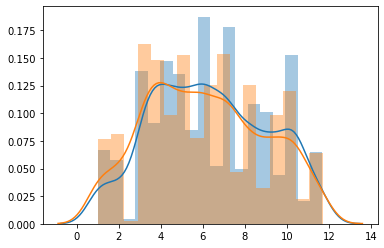

-----------------
 Condition: Sore throat symptom (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


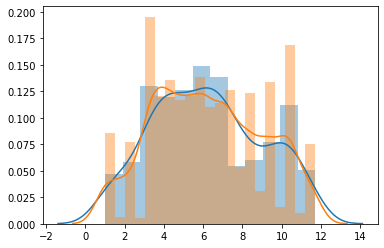

-----------------
 Condition: Sputum finding (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


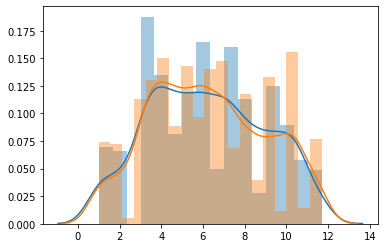

-----------------
 Condition: Fatigue (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


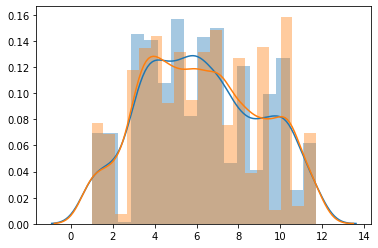

-----------------
 Condition: Dyspnea (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


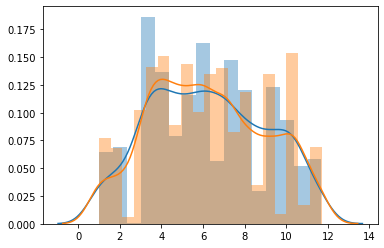

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Wheezing (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


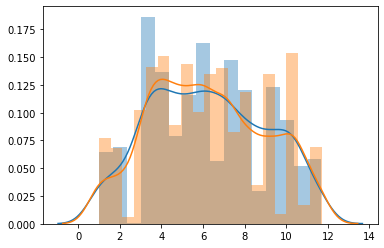

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)


-----------------
 Condition: COVID-19 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


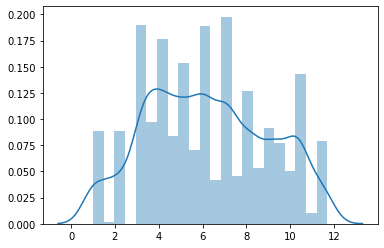

-----------------
 Condition: Body mass index 30+ - obesity (finding) 
-----------------


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


PointbiserialrResult(correlation=nan, pvalue=nan)


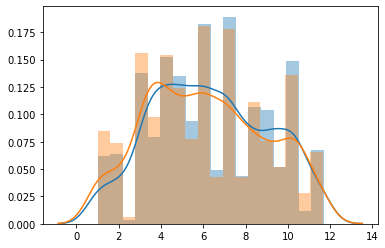

-----------------
 Condition: Normal pregnancy 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


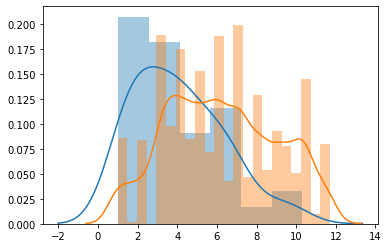

-----------------
 Condition: Diabetes 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


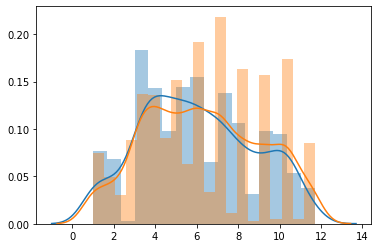

-----------------
 Condition: Traumatic brain injury (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


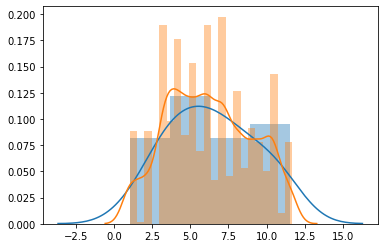

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Hypertriglyceridemia (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


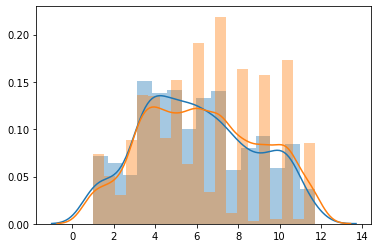

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Metabolic syndrome X (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


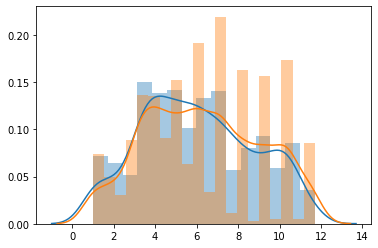

-----------------
 Condition: Chronic kidney disease stage 2 (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


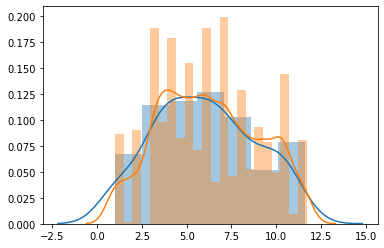

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Diabetic renal disease (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


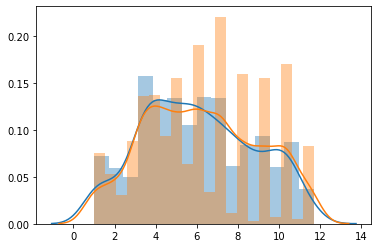

-----------------
 Condition: Microalbuminuria due to type 2 diabetes mellitus (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


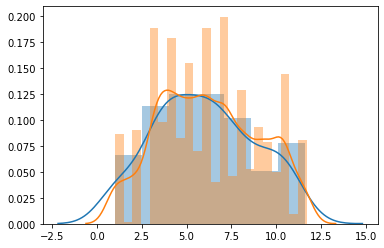

-----------------
 Condition: Pneumonia (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


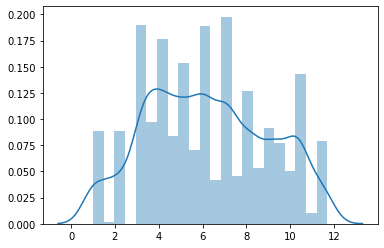

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Hypoxemia (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


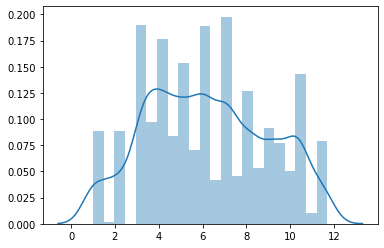

-----------------
 Condition: Respiratory distress (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


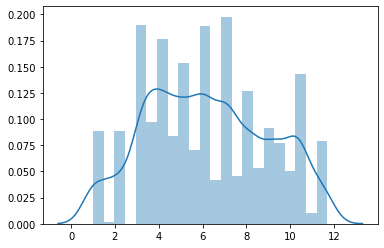

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Acute deep venous thrombosis (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


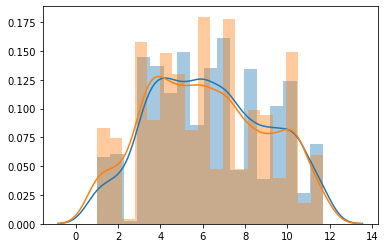

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Miscarriage in first trimester 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


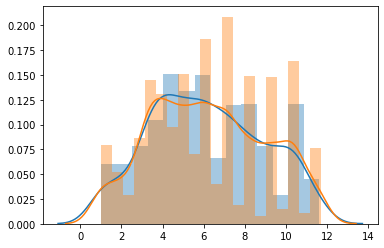

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Viral sinusitis (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


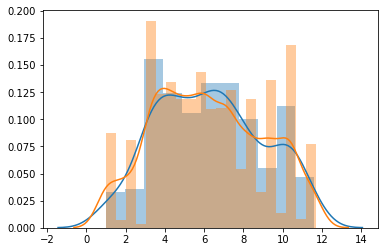

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Loss of taste (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


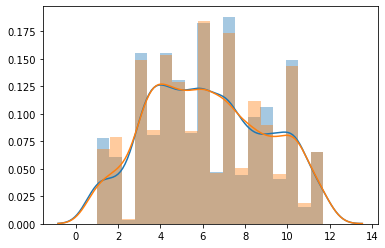

-----------------
 Condition: Alcoholism 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


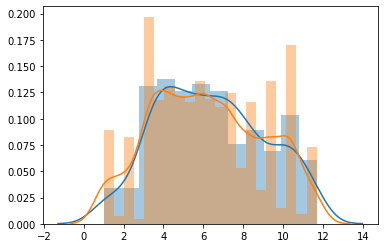

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Nausea (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


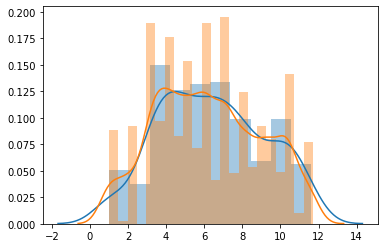

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Vomiting symptom (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


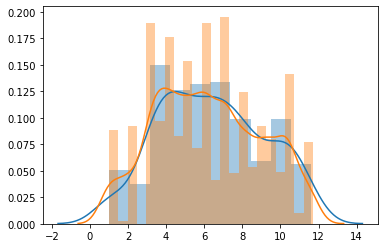

-----------------
 Condition: Smokes tobacco daily 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


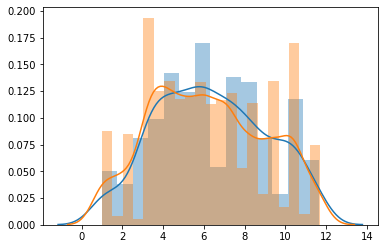

-----------------
 Condition: Headache (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


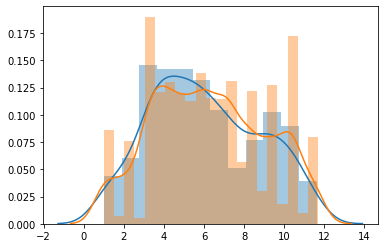

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Chronic sinusitis (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


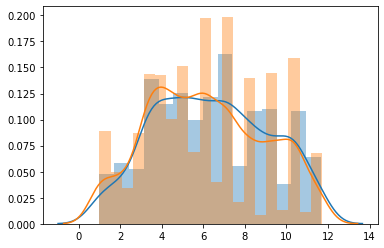

-----------------
 Condition: Osteoarthritis of knee 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


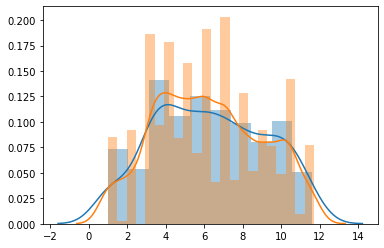

-----------------
 Condition: Concussion with no loss of consciousness 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


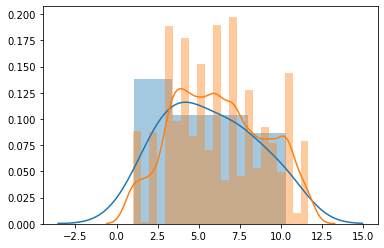

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Acute respiratory failure (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


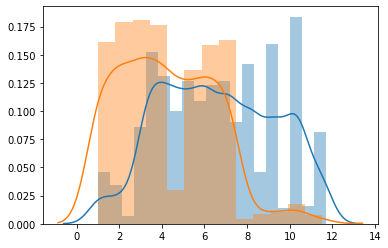

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Sepsis caused by virus (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


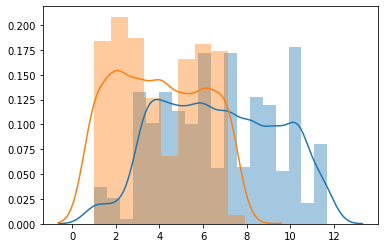

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Septic shock (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


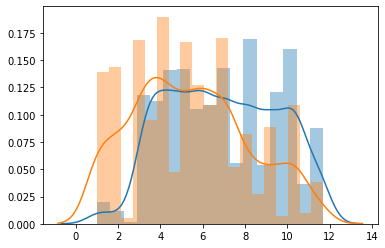

-----------------
 Condition: Heart failure (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


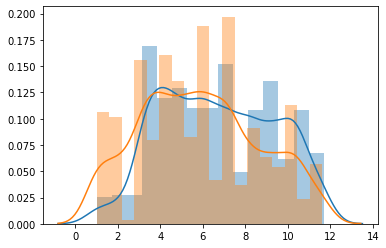

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Acute respiratory distress syndrome (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


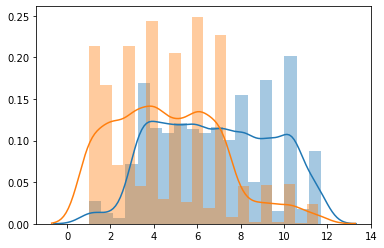

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Bacterial infectious disease (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


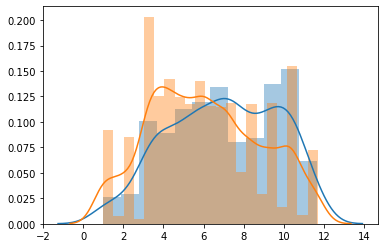

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Acute pulmonary embolism (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


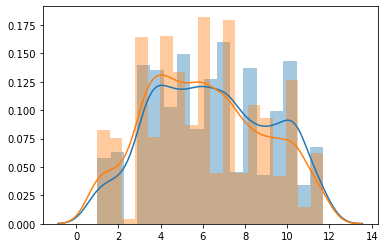

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Tubal pregnancy 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


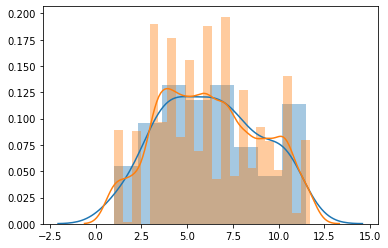

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Pulmonary emphysema (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


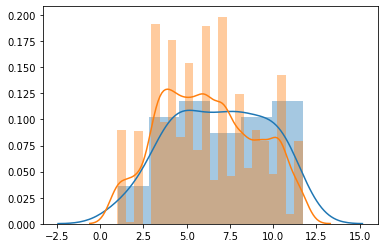

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Suspected lung cancer (situation) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


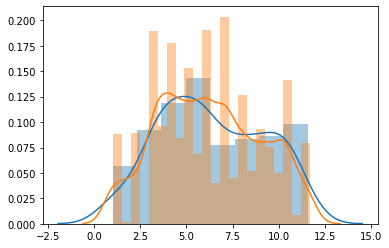

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Non-small cell lung cancer (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


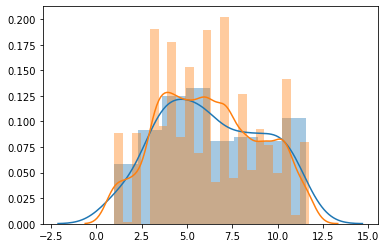

-----------------
 Condition: Non-small cell carcinoma of lung  TNM stage 1 (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


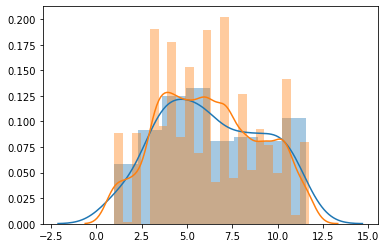

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Rupture of appendix 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


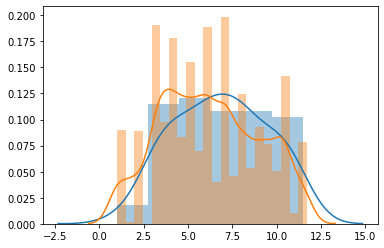

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Appendicitis 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


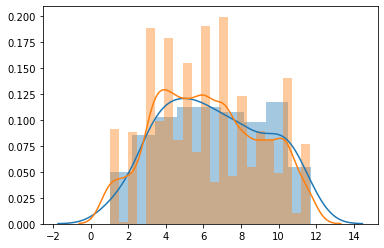

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: History of appendectomy 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


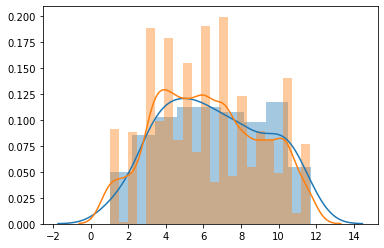

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Chronic pain 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


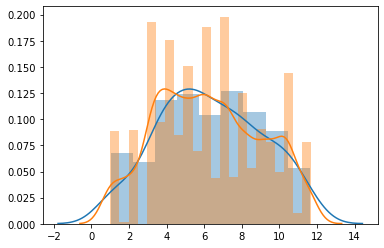

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Chronic intractable migraine without aura 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


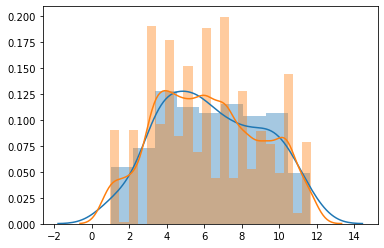

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Impacted molars 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


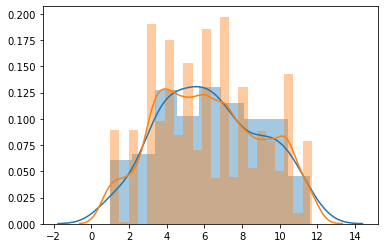

-----------------
 Condition: Opioid abuse (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


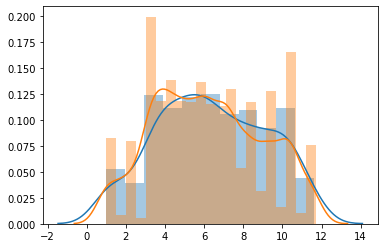

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Cardiac Arrest 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


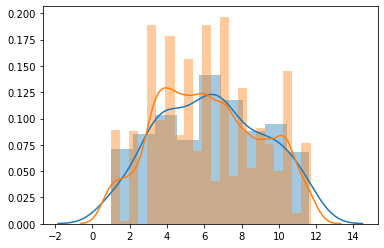

-----------------
 Condition: History of cardiac arrest (situation) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


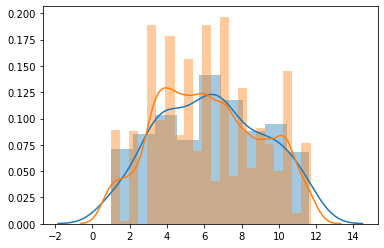

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Sprain of wrist 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


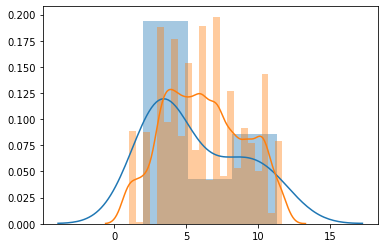

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Malignant neoplasm of breast (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


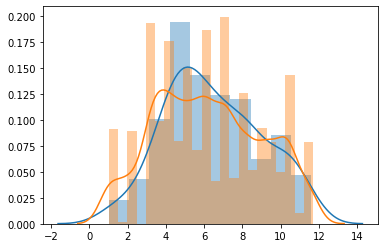

-----------------
 Condition: Hyperglycemia (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


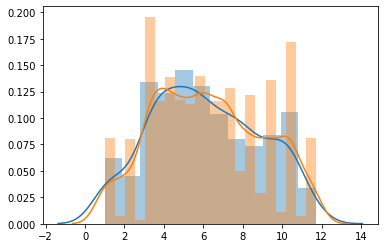

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Diabetic retinopathy associated with type II diabetes mellitus (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


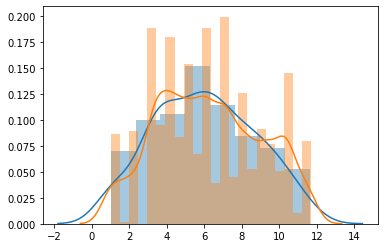

-----------------
 Condition: Nonproliferative diabetic retinopathy due to type 2 diabetes mellitus (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


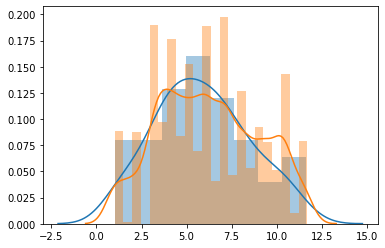

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Fracture of forearm 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


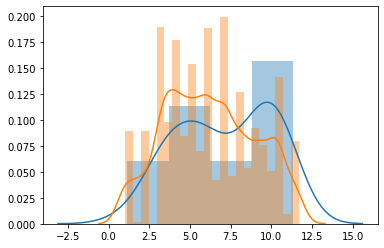

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Stroke 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


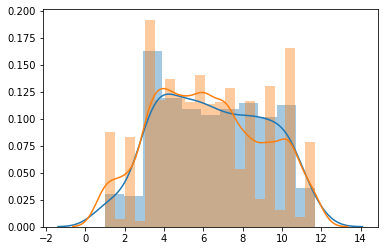

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Chronic kidney disease stage 1 (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


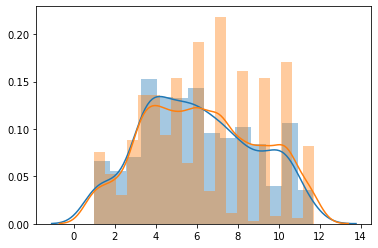

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Neoplasm of prostate 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


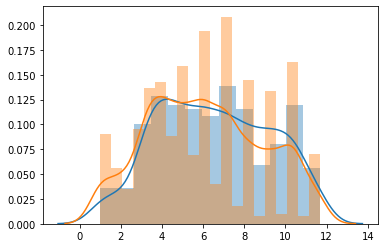

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Carcinoma in situ of prostate (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


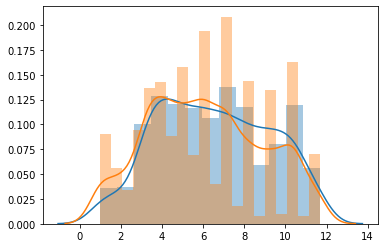

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Neuropathy due to type 2 diabetes mellitus (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


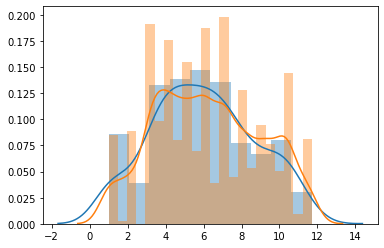

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Osteoporosis (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


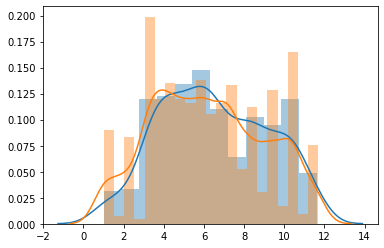

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Hyperlipidemia 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


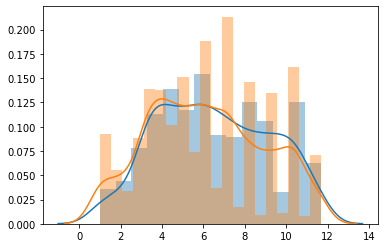

-----------------
 Condition: Bleeding from anus 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


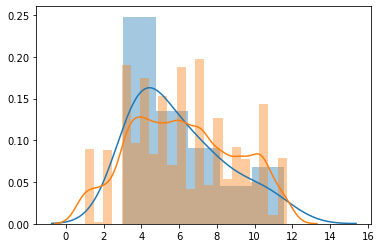

-----------------
 Condition: Protracted diarrhea 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


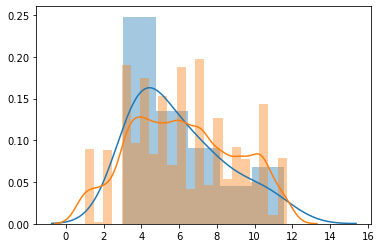

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Atrial Fibrillation 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


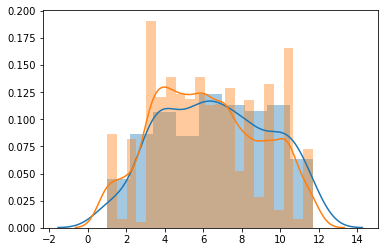

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Drug overdose 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


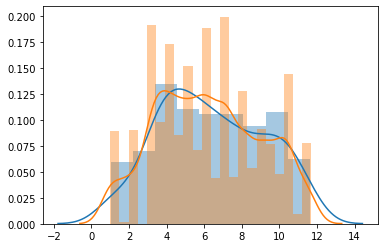

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Polyp of colon 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


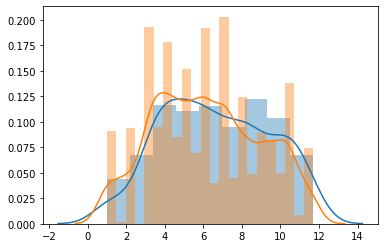

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Recurrent rectal polyp 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


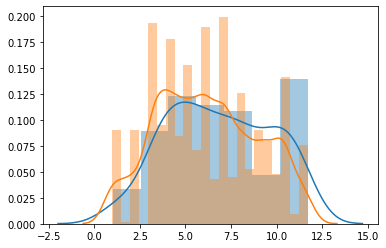

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Chronic congestive heart failure (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


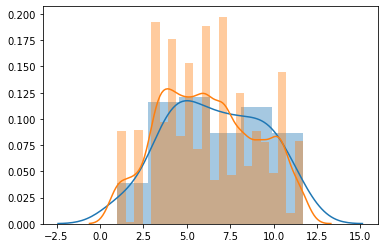

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Perennial allergic rhinitis with seasonal variation 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


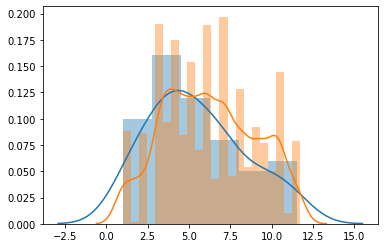

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Localized  primary osteoarthritis of the hand 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


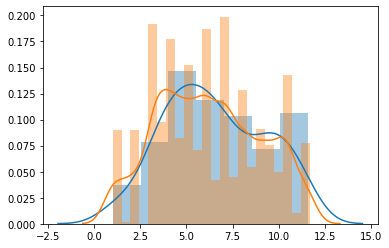

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Otitis media 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


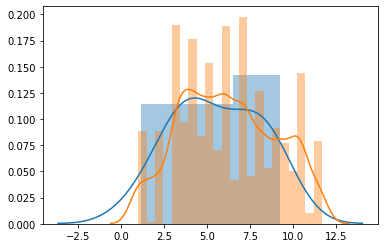

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Muscle pain (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


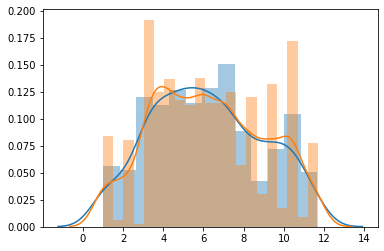

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Joint pain (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


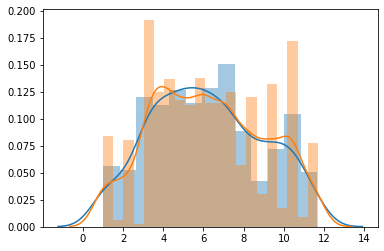

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Acute bronchitis (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


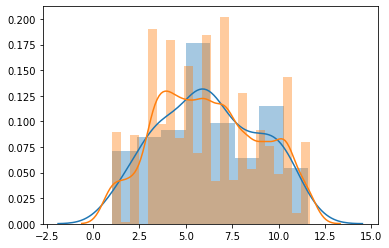

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Overlapping malignant neoplasm of colon 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


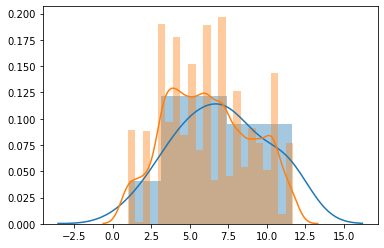

-----------------
 Condition: Body mass index 40+ - severely obese (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


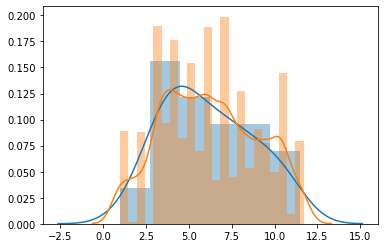

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Osteoarthritis of hip 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


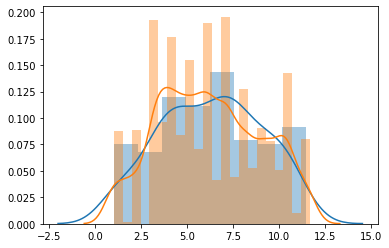

-----------------
 Condition: Fracture of rib 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


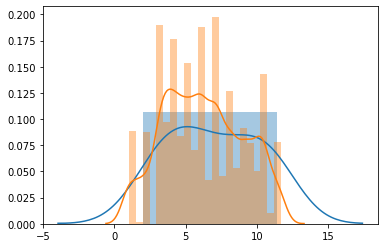

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Seasonal allergic rhinitis 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


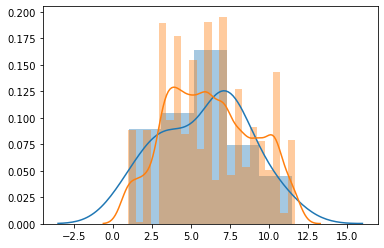

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Alzheimer's disease (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


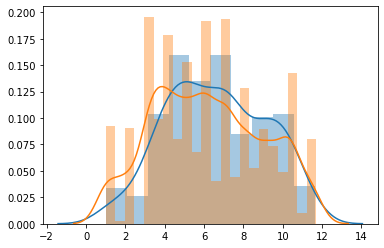

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Acquired coagulation disorder (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


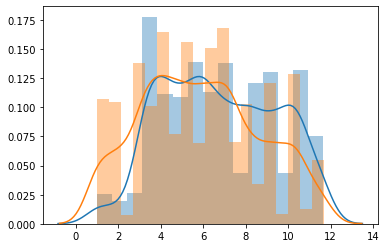

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Injury of kidney (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


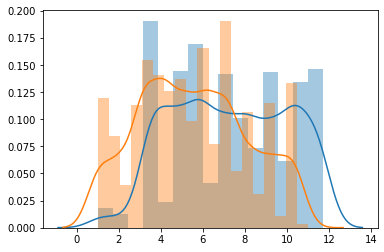

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Secondary malignant neoplasm of colon 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


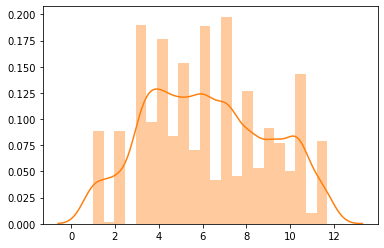

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Acute bacterial sinusitis (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


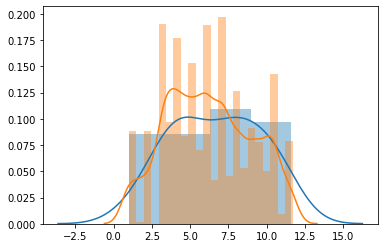

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Perennial allergic rhinitis 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


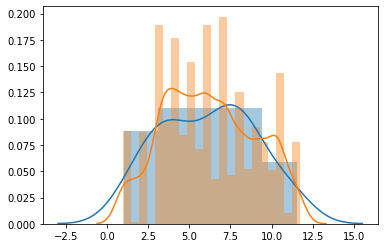

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Primary fibromyalgia syndrome 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


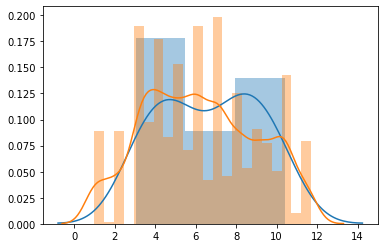

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Diarrhea symptom (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


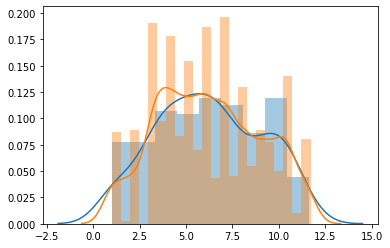

-----------------
 Condition: Injury of heart (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


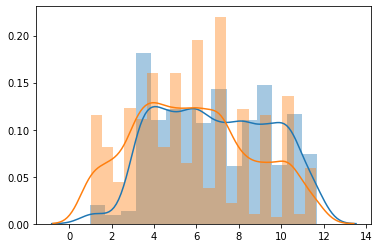

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Fracture of clavicle 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


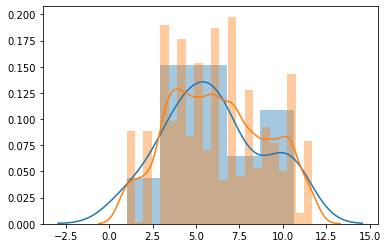

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Escherichia coli urinary tract infection 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


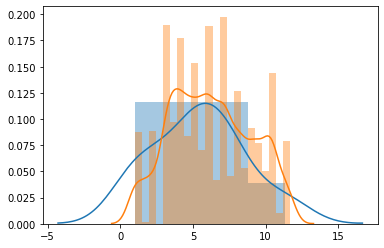

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Laceration of foot 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


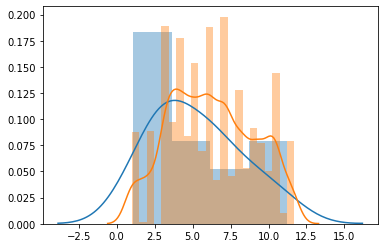

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Seizure disorder 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


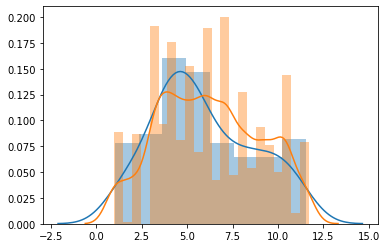

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: History of single seizure (situation) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


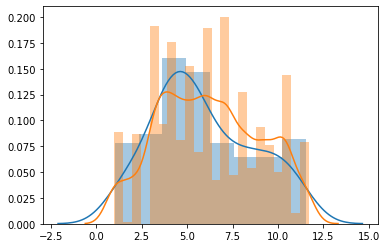

-----------------
 Condition: Epilepsy 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


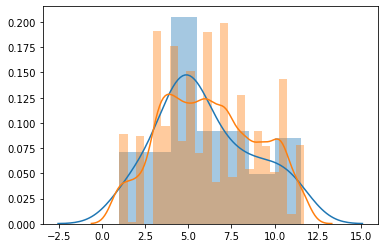

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Passive conjunctival congestion (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


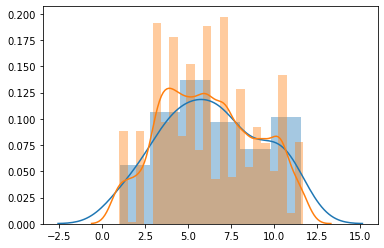

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Recurrent urinary tract infection 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


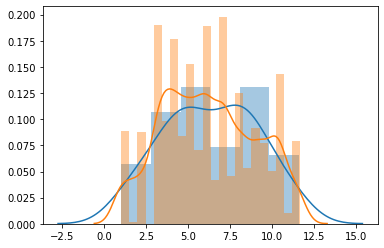

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Small cell carcinoma of lung (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


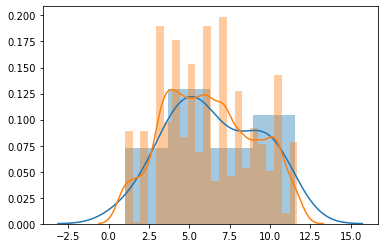

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


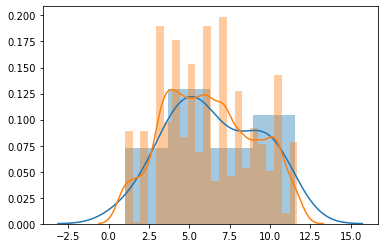

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Male Infertility 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


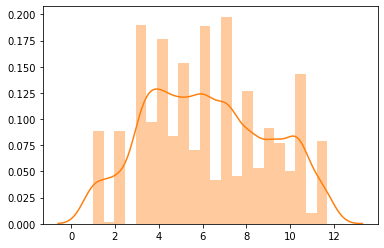

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Cystic Fibrosis 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


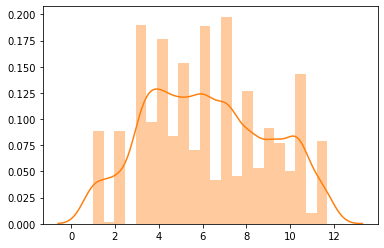

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Infection caused by Pseudomonas aeruginosa 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


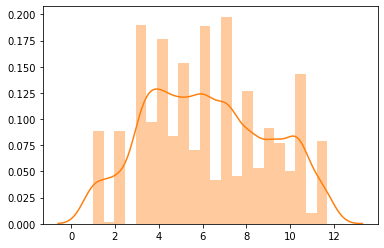

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Sepsis caused by Pseudomonas (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


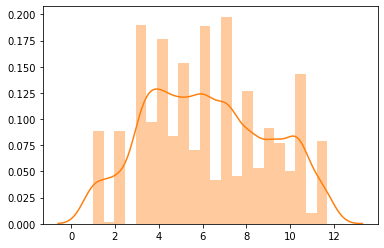

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Proliferative diabetic retinopathy due to type II diabetes mellitus (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


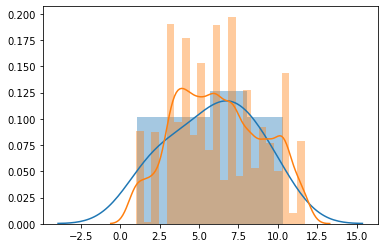

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: First degree burn 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


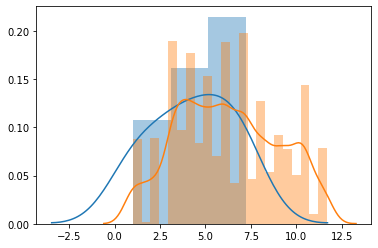

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Chronic obstructive bronchitis (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


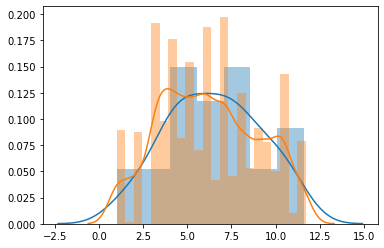

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Facial laceration 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


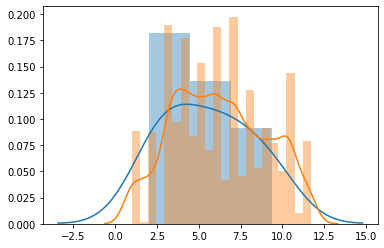

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Laceration of hand 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


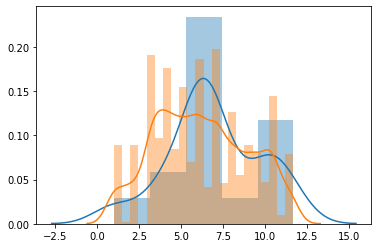

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Fracture of ankle 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


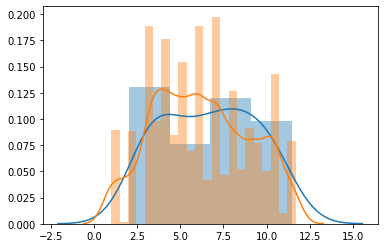

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Familial Alzheimer's disease of early onset (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


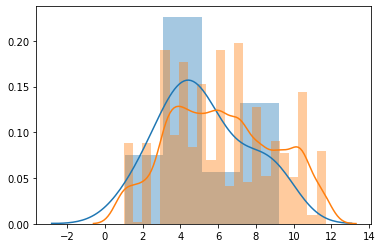

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Malignant tumor of colon 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


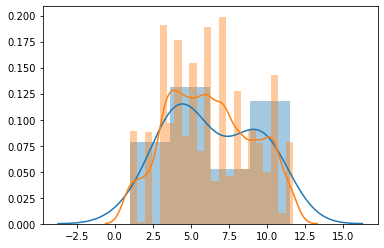

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Sprain of ankle 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


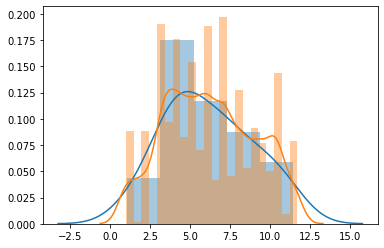

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Macular edema and retinopathy due to type 2 diabetes mellitus (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


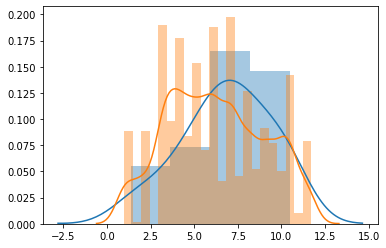

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Atopic dermatitis 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


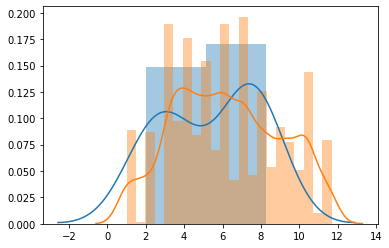

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Fracture subluxation of wrist 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


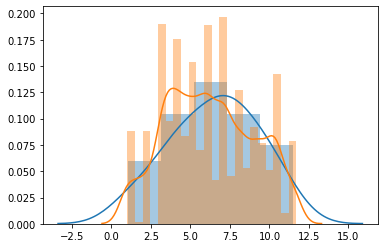

-----------------
 Condition: Cystitis 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


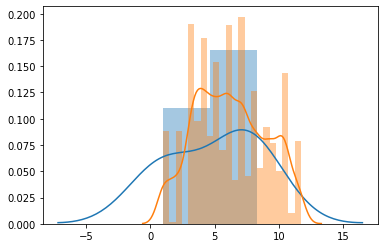

-----------------
 Condition: Bullet wound 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


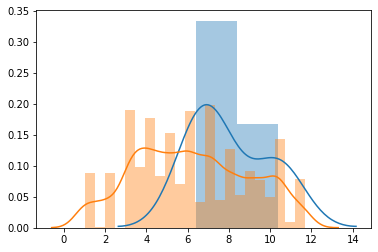

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Laceration of thigh 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


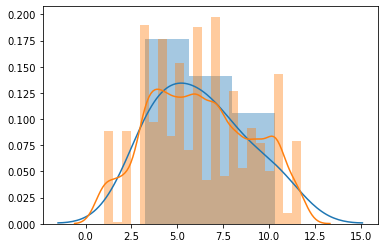

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Metastasis from malignant tumor of prostate (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


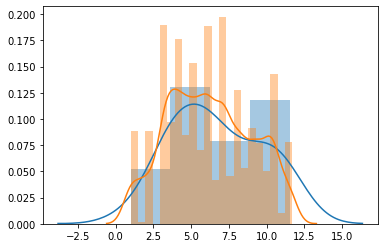

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Posttraumatic stress disorder 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


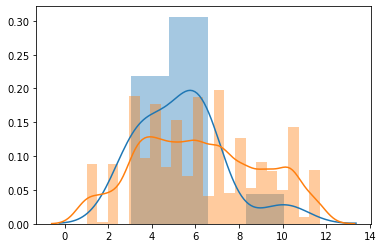

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Gout 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


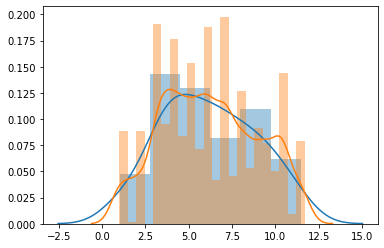

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Second degree burn 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


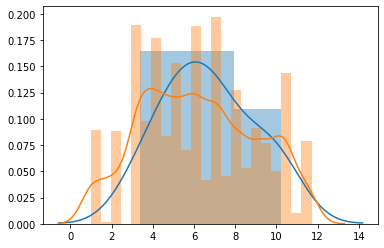

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Closed fracture of hip 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


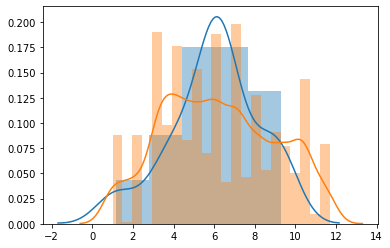

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Pathological fracture due to osteoporosis (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


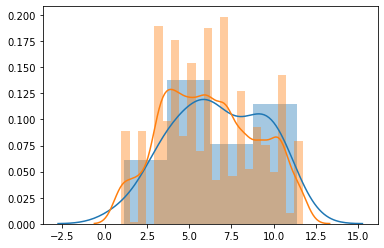

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Streptococcal sore throat (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


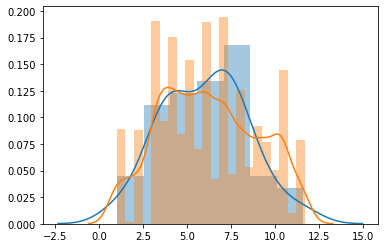

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Concussion injury of brain 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


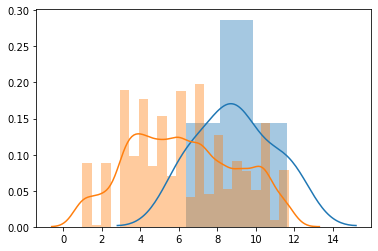

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Brain damage - traumatic 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


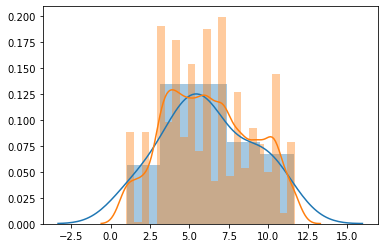

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Female Infertility 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


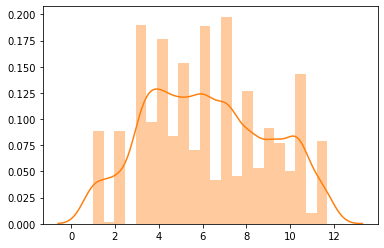

-----------------
 Condition: Preeclampsia 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


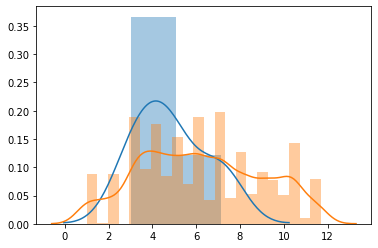

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Chronic paralysis due to lesion of spinal cord 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


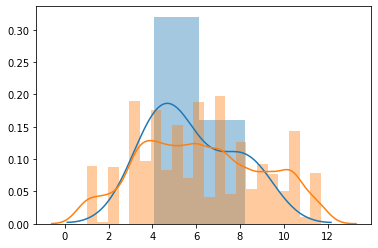

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Idiopathic atrophic hypothyroidism 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


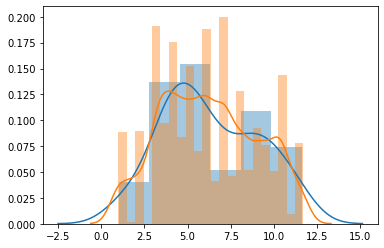

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Rheumatoid arthritis 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


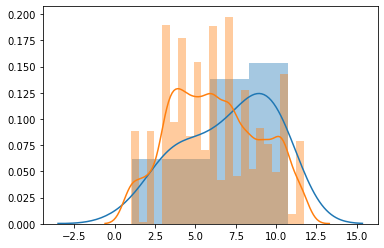

-----------------
 Condition: Fetus with unknown complication 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


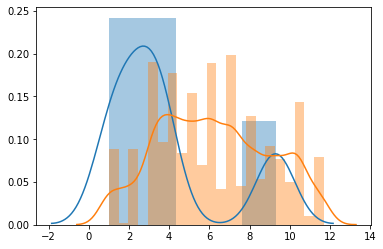

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Hemoptysis (finding) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


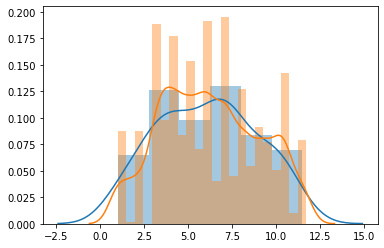

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Injury of anterior cruciate ligament 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


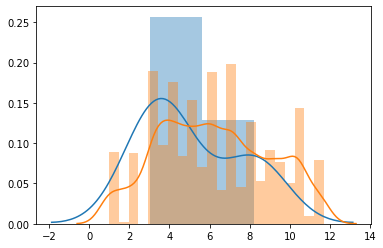

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Sinusitis (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


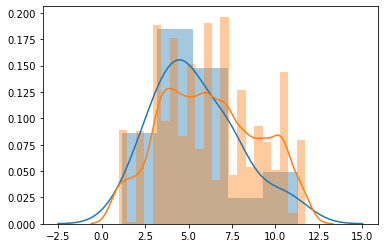

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Concussion with loss of consciousness 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


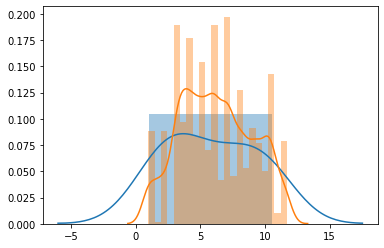

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


-----------------
 Condition: History of amputation of foot (situation) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


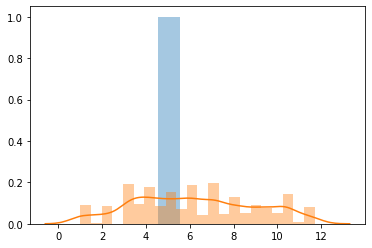

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Whiplash injury to neck 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


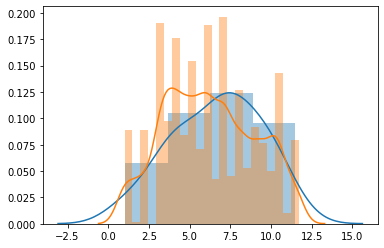

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Antepartum eclampsia 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


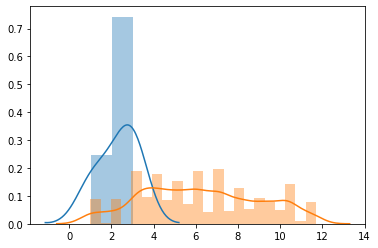

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Primary malignant neoplasm of colon 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


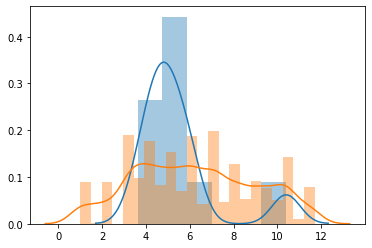

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Laceration of forearm 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


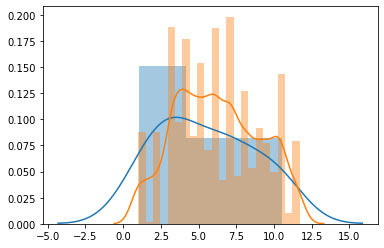

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Acute allergic reaction 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


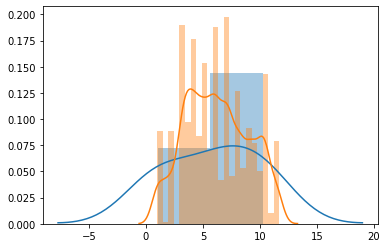

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Injury of medial collateral ligament of knee 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


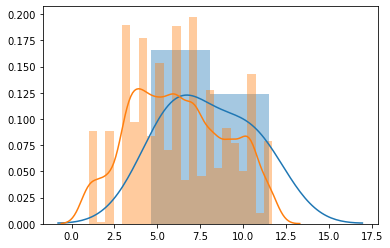

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Child attention deficit disorder 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


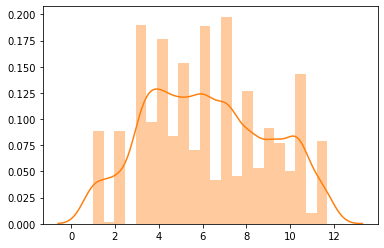

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Injury of tendon of the rotator cuff of shoulder 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


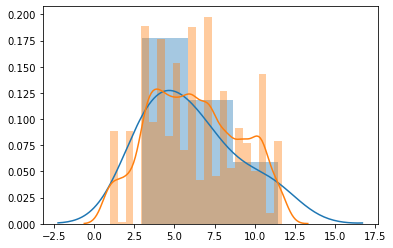

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


-----------------
 Condition: Fracture of vertebral column without spinal cord injury 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


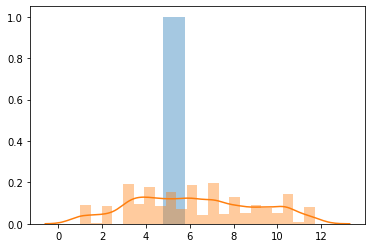

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Blighted ovum 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


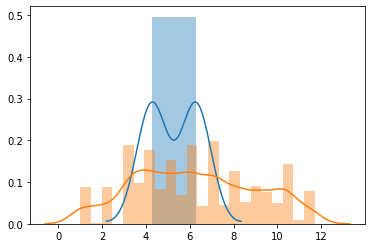

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Rupture of patellar tendon 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


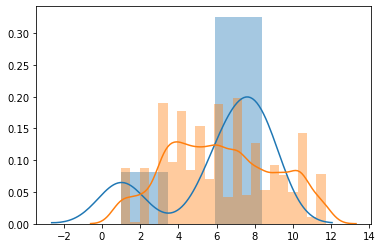

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


-----------------
 Condition: Tear of meniscus of knee 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


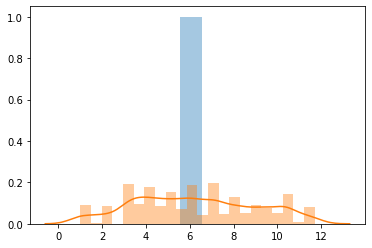

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Fracture of the vertebral column with spinal cord injury 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


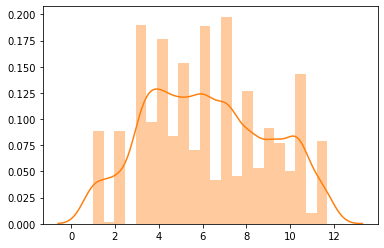

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Asthma 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


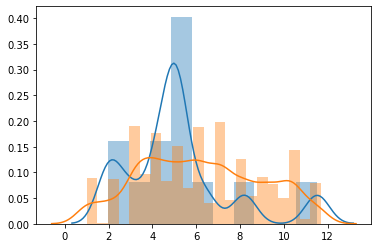

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Burn injury(morphologic abnormality) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


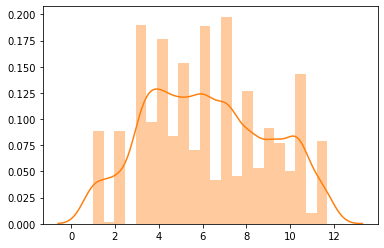

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Contact dermatitis 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


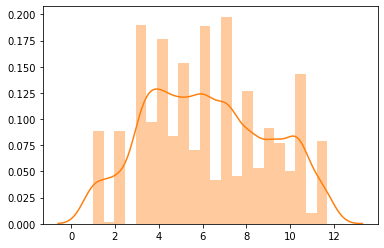

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Chronic kidney disease stage 3 (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


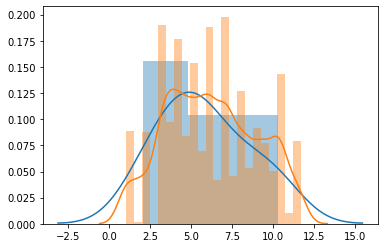

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Proteinuria due to type 2 diabetes mellitus (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


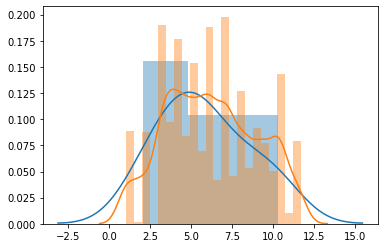

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: History of lower limb amputation (situation) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


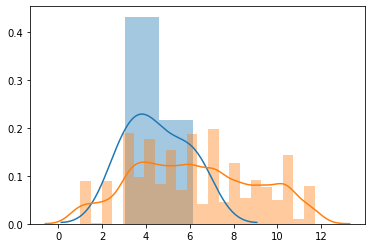

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Infection caused by Staphylococcus aureus 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


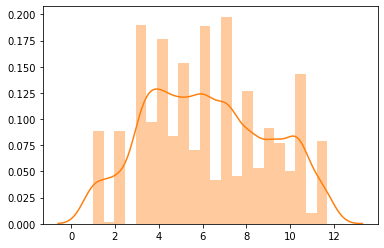

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Sepsis caused by Staphylococcus aureus 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


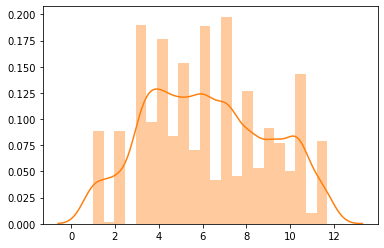

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Pyelonephritis 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


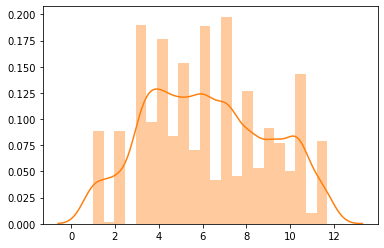

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Lupus erythematosus 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


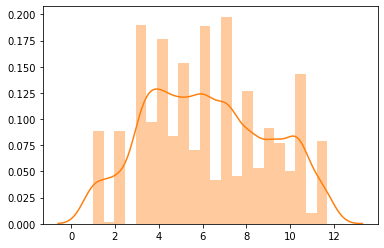

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Childhood asthma 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


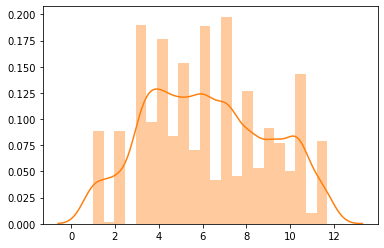

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Non-small cell carcinoma of lung  TNM stage 2 (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


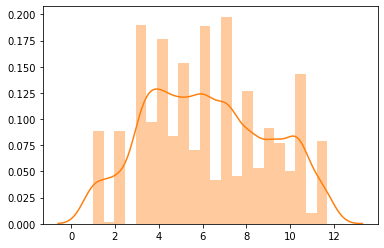

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Acute Cholecystitis 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


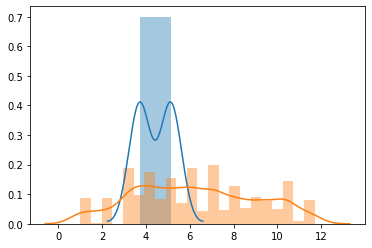

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Cholelithiasis 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


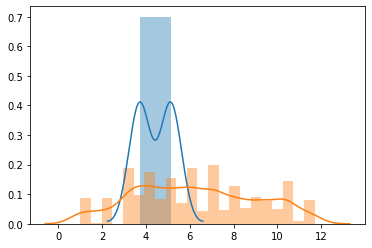

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Suicidal deliberate poisoning 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


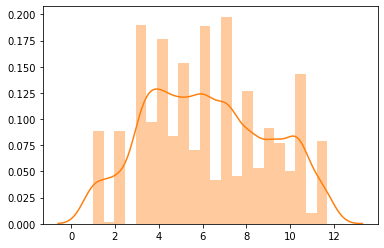

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Major depression  single episode 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


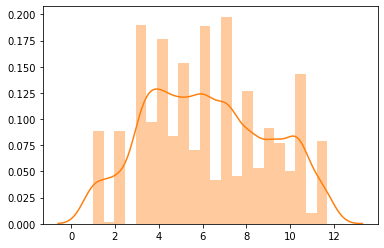

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Non-low risk pregnancy 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


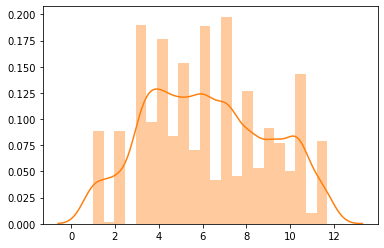

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: Third degree burn 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


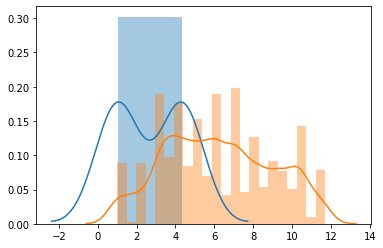

-----------------
 Condition: Blindness due to type 2 diabetes mellitus (disorder) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


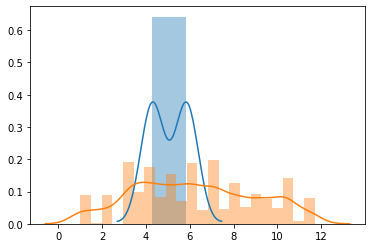

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-----------------
 Condition: History of upper limb amputation (situation) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


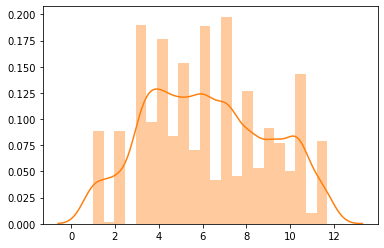

C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


-----------------
 Condition: Meconium Ileus 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


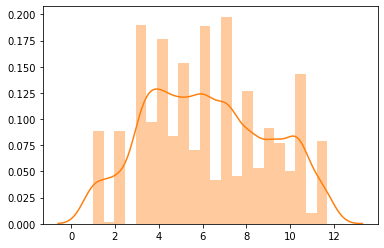

-----------------
 Condition: Attempted suicide - cut/stab 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


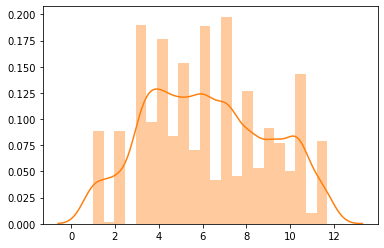

-----------------
 Condition: History of disarticulation at wrist (situation) 
-----------------
PointbiserialrResult(correlation=nan, pvalue=nan)


C:\Users\Jimmy\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Jimmy\Anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jimmy\Anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


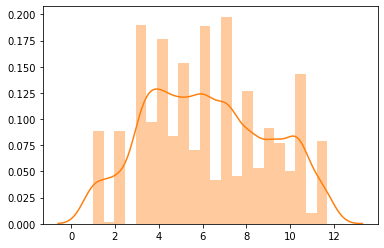

In [246]:
for condition in conditions:
    print(f'-----------------\n Condition: {condition_description[condition]} \n-----------------')
    X_cond = icu_target[icu_target.index.isin(list(condition_dictionary[condition]))].values.flatten()
    X_no_cond = icu_target[~icu_target.index.isin(list(condition_dictionary[condition]))].values.flatten()
    X = np.concatenate([X_cond, X_no_cond])
    Y = np.concatenate([np.zeros(len(X_cond)), np.zeros(len(X_no_cond))])
    print(stats.pointbiserialr(Y, X))
    sns.distplot(X_cond)
    sns.distplot(X_no_cond)
    plt.show()

In [252]:
for condition in condition_description.keys():
    if condition_description[condition] in ['Acute respiratory failure (disorder)', 
                                            'Sepsis caused by virus (disorder)',
                                            'Septic shock (disorder)',
                                            'Acute respiratory distress syndrome (disorder)',
                                            'Injury of kidney (disorder)',
                                            'Injury of heart (disorder)',
                                            'Rheumatoid arthritis',
                                            'Asthma']:
        print(condition)

65710008
770349000
76571007
67782005
40095003
86175003
69896004
195967001


In [251]:
X = [65710008, 770349000, 76571007, 67782005, 40095003, 86175003, 69896004, 195967001]
[condition_description[x] for x in X]

['Sepsis caused by virus (disorder)',
 'Septic shock (disorder)',
 'Acute respiratory distress syndrome (disorder)',
 'Injury of kidney (disorder)',
 'Injury of heart (disorder)',
 'Rheumatoid arthritis',
 'Asthma']

In [254]:
condition_dictionary[conditions[0]]

array(['93fa6213-73a1-4cce-b408-9986a4145801',
       'c58ae02e-235e-4db2-a9c3-6926e9c0c5fa',
       'b19b626b-7e2a-4adc-98a8-dd17676b7d83', ...,
       '39d9a5f4-196c-4a12-90e9-5372b03f202c',
       '9f430ccd-8c0d-4616-bbe4-78e220094c04',
       '8722685f-ce37-4520-ab95-22b6929526c2'], dtype=object)